In [1]:
# import numpy and exp mat
import numpy as np
from math import exp, sqrt
# import njit
from numba import njit
from numba.experimental import jitclass

# import timeit
import timeit
# import time
import time

from numba import int32, float64, types

# import random
import random

import matplotlib.pyplot as plt

%matplotlib widget

# numpy random seed
np.random.seed(0)

In [2]:
# the class QuantumSystem have the following attributes:
# - N: number of particles
# - D: number of dimensions
# - params: variational parameters (array)

# and the following methods:
# - __init__: initialize the system
# - set_params: set the variational parameters
# - wavefunction: compute the wavefunction
# - local_energy: compute the local energy

spec = [
    ('N', int32),
    ('D', int32),
    ('params', float64[:]),  # assuming params is a 1D array of floats
]

@jitclass(spec)
class QuantumSystem:
    def __init__(self, N, D, params=np.array([0.])):
        self.N = N
        self.D = D
        self.params = params

    def set_params(self, params):
        # set the variational parameters
        self.params = params

    def wavefunction(self, X):
        # compute the wavefunction
        return exp(-self.params[0]*np.sum(X**2))
    
    def log_wavefunction(self, X):
        # compute the log of the wavefunction
        return -self.params[0]*np.sum(X**2)
    
    def local_energy(self, X):
        # compute the local energy
        return self.N*self.D*self.params[0] + (0.5 - 2*self.params[0]**2)*np.sum(X**2)
    

In [3]:
# the class MetropolisWalker have the following attributes:
# - system: the quantum system
# - X: the initial position (if None, gauss is used)
# - delta: the step size
# - subgroup_size: subgroup of particle to move

# and the following methods:
# - __init__: initialize the walker
# - step: make a step
# - propose: propose a move
# - test: test the move
# - get_chain: get the chain of positions

spec = [
    ('system', QuantumSystem.class_type.instance_type),
    ('X', float64[:,:]),
    ('delta', float64),
    ('subgroup_size', int32),
]

@jitclass(spec)
class MetropolisWalker:
    def __init__(self, system, X=None, delta=None, subgroup_size=None):
        self.system = system

        if X is None:
            self.X = np.random.randn(self.system.N, self.system.D)
        else:
            self.X = X

        if subgroup_size is None and delta is None:
            self.subgroup_size = int(system.N/3)
            self.delta = 1.0/np.sqrt(self.subgroup_size)
        
        if subgroup_size is None and delta is not None:
            self.subgroup_size = int(system.N/3)
            self.delta = delta
        
        if subgroup_size is not None and delta is None:
            self.subgroup_size = subgroup_size
            self.delta = 1.0/np.sqrt(self.subgroup_size)
       

    def step(self):
        # make a step
        X_new = self.propose()  
        if self.test(X_new):
            self.X = X_new

    def propose(self):
        # propose a move
        # random sample of subgroup_size particles, no repetition
        subgroup_indx = np.random.choice(self.system.N, self.subgroup_size, replace=False)
        dX = np.zeros((self.system.N, self.system.D)) 
        dX[subgroup_indx] = (np.random.randn(self.subgroup_size,self.system.D))*self.delta
        return self.X + dX

    def test(self, X_new):
        # test the move
        likelihood = np.exp(2*(self.system.log_wavefunction(X_new) - self.system.log_wavefunction(self.X)))
        return np.random.random() < likelihood

    def get_chain(self, n_steps):
        # get a chain
        chain = np.zeros((n_steps, self.system.N, self.system.D))
        for i in range(n_steps):
            self.step()
            chain[i] = self.X
        return chain

In [4]:
# the class Analizer have the following attributes:
# - system: the quantum system
# - chain: the chain of positions

# and the following methods:
# - __init__: initialize the analizer
# - get_local_energies: get the local energies
# - get_acceptance_rate: get the acceptance rate
# - block_transform: block transform the energies
# - get_block_std: get the block standard deviation

@njit
def get_acceptance_rate(local_energies):
    # get the local energies, make np.diff and count how many zeros
    return np.count_nonzero(np.diff(local_energies))/len(local_energies)

@njit
def get_local_energies(system, chain):
        # get the local energies
        return np.array([system.local_energy(X) for X in chain])

@njit
def block_transform(energies):
    energies_prime = np.zeros(len(energies)//2)
    for i in range(len(energies)//2):
        energies_prime[i] = 0.5*(energies[2*i] + energies[2*i+1])
    return energies_prime

@njit
def get_block_std(energies):
    energies_prime = energies
    block_std = np.zeros(int(np.log2(len(energies_prime))))
    for i in range(len(block_std)-1):
        energies_prime = block_transform(energies_prime)
        block_std[i] = np.std(energies_prime)/sqrt(len(energies_prime) - 1)
    return block_std




class Analizer:
    def __init__(self, system, chain, block_quantiles=0.8):
        self.system = system
        self.chain = chain
        self.block_quantiles = block_quantiles

        self.local_energies = get_local_energies(self.system, self.chain)
        self.block_std = None

    def get_local_energies(self):
        return self.local_energies

    def get_acceptance_rate(self):
        return get_acceptance_rate(self.local_energies)
    
    def get_block_std(self):
        self.block_std = get_block_std(self.local_energies)
        return self.block_std
    
    def get_mean_energy(self):
        return np.mean(self.local_energies)
    
    def get_std_energy(self):
        self.get_block_std()
        return np.sort(self.block_std)[int(self.block_quantiles*len(self.block_std))]

In [5]:
# the VMC class have the following attributes:
# - system: the quantum system
# - walker: the metropolis walker
# - warmup_steps: number of warmup steps
# - run_steps: number of steps
# - params: the variational parameters
# - plot: if True plot the results (plt.show, otherwise plt.savefig)
# - warmup_chain: warmup chain
# - run_chain: integral chain
# - plot_dir: directory to save the plot

# and the following methods:
# - __init__: initialize the VMC
# - warmup: warmup the VMC
# - run: integrate the VMC
# - get_energy: get the energy
# - get_energy_std: get the energy standard deviation using blocking


class VMC:
    def __init__(self, system, walker, 
                 params=np.array([0.]),
                 warmup_steps=1000, run_steps=10000,
                 calibrate_steps=10000, batch_steps=1000, acceptace=0.5, factor=0.8,
                 block_quantiles=0.8,
                 plot=False, plot_dir=None, verbose=False):
        self.system = system
        self.walker = walker

        self.params = params

        self.warmup_steps = warmup_steps
        self.run_steps = run_steps

        self.calibrate_steps = calibrate_steps
        self.batch_steps = batch_steps
        self.acceptace = acceptace
        self.factor = factor

        self.block_quantiles = block_quantiles

        self.plot = plot
        self.save_plot = plot_dir
        self.verbose = verbose

        self.warmup_chain = None
        self.run_chain = None
        self.run_analizer = None
        self.run_time = None

        self.system.set_params(self.params)

    def set_params(self, params):   
        # set the variational parameters
        self.params = params
        self.system.set_params(self.params)

    def warmup(self):
        # warmup the VMC
        self.warmup_chain = self.walker.get_chain(self.warmup_steps)

        if self.verbose:
            analizer = Analizer(self.system, self.warmup_chain)
            print('-----------------')
            print('VMC warmup')
            print('-----------------')
            print('Parameters:', self.params)
            print('Acceptance rate:', analizer.get_acceptance_rate())

        if self.plot or self.save_plot is not None:
            analizer = Analizer(self.system, self.warmup_chain)
            plt.figure()
            plt.plot(analizer.get_local_energies())
            plt.xlabel('steps')
            plt.ylabel('loc energy')
            name = 'Warmup, params:'
            for p in self.params:
                name += '_'+('%.3f' % p)
            plt.title(name)
            plt.grid()
            if self.save_plot is not None:
                # make a name that contains the params
                plt.savefig(self.save_plot+name+'.png')
            if self.plot:
                plt.show()
            if self.plot == False:
                plt.close()
        
    def run(self):
        # integrate the VMC

        # if verbose measure the time
        start = time.time()
        self.run_chain = self.walker.get_chain(self.run_steps)
        self.run_analizer = Analizer(self.system, self.run_chain, self.block_quantiles)
        end = time.time()
        self.run_time = end-start

        if self.verbose:
            # print the parameters, acceptance rate and energy and std
            print('-----------------')
            print('VMC run')
            print('-----------------')
            print('Parameters:', self.params)
            print('Acceptance rate:', self.run_analizer.get_acceptance_rate())
            print('Time: ', self.run_time)
            print('Energy:', self.run_analizer.get_mean_energy(), '+/-', self.run_analizer.get_std_energy())

        if False:
            plt.figure()
            plt.plot(self.run_analizer.get_local_energies())
            plt.xlabel('steps')
            plt.ylabel('loc energy')
            name = 'Run, params:'
            for p in self.params:
                name += '_'+('%.3f' % p)
            plt.title(name)
            plt.grid()
            if self.save_plot is not None:
                # make a name that contains the params
                plt.savefig(self.save_plot+name+'.png')
            if self.plot:
                plt.show()
            if self.plot == False:
                plt.close()
                
        if self.plot or self.save_plot is not None:
            plt.figure()
            block_std = self.run_analizer.get_block_std()[:-1]
            energy_std = np.sort(block_std)[int(len(block_std)*self.block_quantiles)]
            plt.plot(block_std, 'o')
            plt.xlabel('blocking')
            plt.ylabel('loc energy std')
            plt.axhline(y=energy_std, color='r', linestyle='--')
            name = 'Blocking, params:'
            for p in self.params:
                name += '_'+('%.3f' % p)
            plt.title(name)
            plt.grid()
            if self.save_plot is not None:
                # make a name that contains the params
                plt.savefig(self.save_plot+name+'.png')
            if self.plot:
                plt.show()
            if self.plot == False:
                plt.close()

    def calibrate(self):
        # calibrate the VMC
        for batch in range(self.calibrate_steps//self.batch_steps):
            batch_chain = self.walker.get_chain(self.batch_steps)
            batch_analizer = Analizer(self.system, batch_chain)
            batch_acceptance_rate = batch_analizer.get_acceptance_rate()
            if random.random() < 0.5:
                if batch_acceptance_rate < self.acceptace:
                    self.walker.delta *= self.factor
                if batch_acceptance_rate > self.acceptace:
                    self.walker.delta *= 1/self.factor
            else:
                if batch_acceptance_rate < self.acceptace:
                    self.walker.subgroup_size = int(self.walker.subgroup_size*self.factor)
                    if self.walker.subgroup_size < 1:
                        self.walker.subgroup_size = 1
                if batch_acceptance_rate > self.acceptace:
                    self.walker.subgroup_size = int(self.walker.subgroup_size/self.factor+0.5)
                    if self.walker.subgroup_size > self.system.N:
                        self.walker.subgroup_size = self.system.N
                        
        if self.verbose:
            print('-----------------')
            print('VMC calibrate')
            print('-----------------')
            print('delta:', self.walker.delta)
            print('subgroup_size:', self.walker.subgroup_size)
            print('Acceptance rate:', batch_acceptance_rate)

    def get_energy(self):
        # get the energy
        return self.run_analizer.get_mean_energy()

    def get_energy_std(self):
        return self.run_analizer.get_std_energy()
    
    def get_run_time(self):
        return self.run_time   

# Spherical Harmonic Oscillator without interaction, with Metropolis and analytical hamiltonian
In this notebook we study the Spherical Harmonic Oscillator without interaction, using the Metropolis algorithm and analytical hamiltonian.

In a first part we present an example of our code.
In a second part we perform a grid search to find the optimal variational parameter $\alpha$.
In a third part we show that since the Ansatz correspond to the exact ground state of the hamiltonian, the mean energy with the right variational parameter ($\alpha =0.5$) is the exact groundstate energy of the system.


## Example of the code
In this section we show how the code work, choosing N, D and a variational parameter, we demonstrate how our implementation of the Metropolis algorithm works.

In particular, we show how the calibrate part of the code works, note we do not need to specify the hyperparameter of the Metropolis algorithm, as the $\delta$ step and the number of particles moved per step, since this are optimized to achieve the desired acceptance rate.

In [6]:
# test the classes
N = 100
D = 3

params = np.array([0.6])

system = QuantumSystem(N, D)
walker = MetropolisWalker(system)
vmc = VMC(system, walker, params, 
          warmup_steps=50000, run_steps=1000000,
          calibrate_steps=50000, batch_steps=500, acceptace=0.4,
          verbose=True, plot=True)

In [7]:
vmc.calibrate()

-----------------
VMC calibrate
-----------------
delta: 0.08912775984931731
subgroup_size: 50
Acceptance rate: 0.324


-----------------
VMC warmup
-----------------
Parameters: [0.6]
Acceptance rate: 0.40154


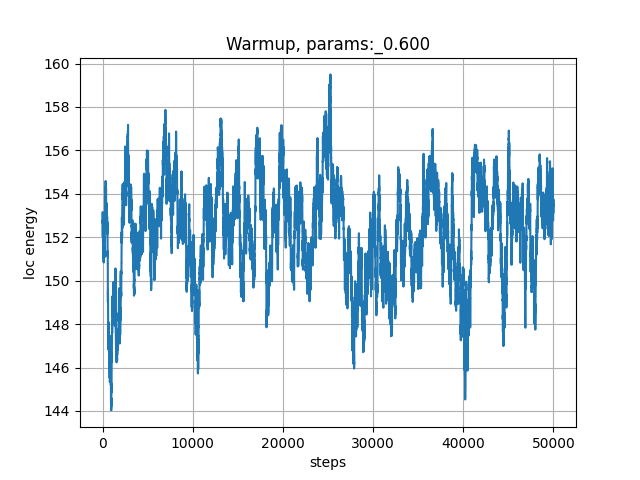

In [8]:
vmc.warmup()

-----------------
VMC run
-----------------
Parameters: [0.6]
Acceptance rate: 0.39931
Time:  13.47806429862976
Energy: 152.55003348448972 +/- 0.07172922821227144


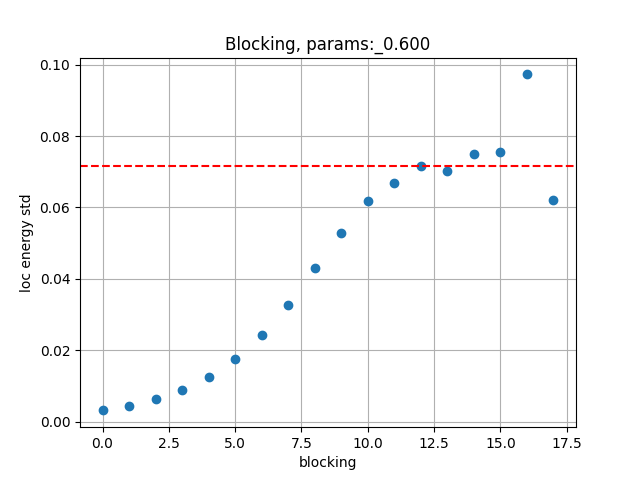

In [9]:
vmc.run()

Comment: the std of the energy as a function of the bloking transformation is a useful tool to understand if the number of steps is enough to have a good estimation of the energy. In particular, if the std is constant, it means that the number of steps is enough to have a good estimation of the energy and his uncertainty.

## Grid search
In this section we perform a grid search of $\alpha$ for fixed N and D.
In particular we save the mean energy, the std of the mean energy and the time of execution for each $\alpha$ then we plot the results.

During a grid search warmup plot of the energies and the blocking plot are saved in a directory, so one can always check if the results are rasonable.

In [10]:
params = np.arange(0.2, 1.0, 0.1)
energies = np.zeros(len(params))
energies_std = np.zeros(len(params))
times = np.zeros(len(params))

plot_dir = 'SHOscillatorMetropolisAnalytical_GridSearch/'

system = QuantumSystem(N, D)
walker = MetropolisWalker(system)
vmc = VMC(system, walker, params, 
          warmup_steps=50000, run_steps=1000000,
          calibrate_steps=50000, batch_steps=500, acceptace=0.3,
          verbose=True, plot=False, plot_dir=plot_dir)

for i, param in enumerate(params):
    vmc.set_params(np.array([param]))
    vmc.calibrate()
    vmc.warmup()
    vmc.run()
    energies[i] = vmc.get_energy()
    energies_std[i] = vmc.get_energy_std()
    times[i] = vmc.get_run_time()

np.save(plot_dir+'energies.npy', energies)
np.save(plot_dir+'energies_std.npy', energies_std)
np.save(plot_dir+'times.npy', times)

-----------------
VMC calibrate
-----------------
delta: 0.8300669477257628
subgroup_size: 3
Acceptance rate: 0.408
-----------------
VMC warmup
-----------------
Parameters: [0.2]
Acceptance rate: 0.29342
-----------------
VMC run
-----------------
Parameters: [0.2]
Acceptance rate: 0.294333
Time:  10.055635213851929
Energy: 217.43652714807945 +/- 0.39697557735642724
-----------------
VMC calibrate
-----------------
delta: 1.6212245072768805
subgroup_size: 1
Acceptance rate: 0.314
-----------------
VMC warmup
-----------------
Parameters: [0.3]
Acceptance rate: 0.2203
-----------------
VMC run
-----------------
Parameters: [0.3]
Acceptance rate: 0.222158
Time:  9.059813737869263
Energy: 170.29275487172086 +/- 0.2373974699628327
-----------------
VMC calibrate
-----------------
delta: 1.0375836846572035
subgroup_size: 1
Acceptance rate: 0.318
-----------------
VMC warmup
-----------------
Parameters: [0.4]
Acceptance rate: 0.3396
-----------------
VMC run
-----------------
Parameters: 

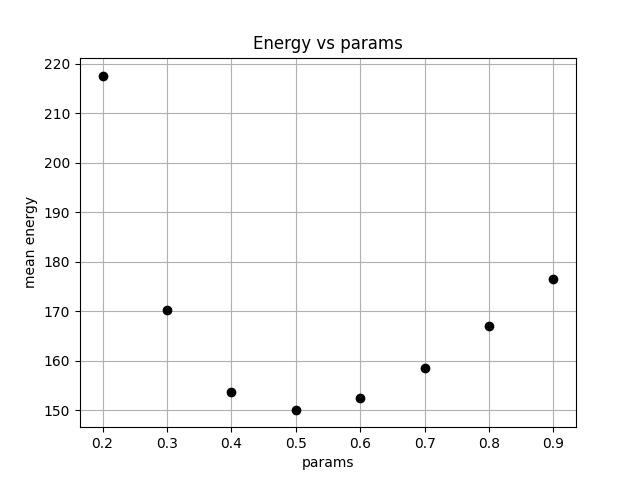

In [11]:
# plot the results
plt.figure()
plt.errorbar(params, energies, yerr=energies_std, fmt='o', color='k')
plt.xlabel('params')
plt.ylabel('mean energy')
plt.title('Energy vs params')
plt.grid()
plt.savefig(plot_dir+'Energy_vs_params.png')

## Compare with analytical results
In this section we compare the results of the grid search with the analytical results, in particular we show that the mean energy is the exact ground state energy of the system.

In [12]:
print('params:', params[np.argmin(energies)])
print('MC mean energy:', np.min(energies), '+-', energies_std[np.argmin(energies)])
print('Analytical energy:', 0.5*N*D, '+-', 0.0)

params: 0.5000000000000001
MC mean energy: 150.0 +- 0.0
Analytical energy: 150.0 +- 0.0
